# Modulação CE-DDO-OFDM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc, signal_power
from optic.core        import parameters
from optic.models      import ssfm, photodiode

from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR
from commpy.utilities  import upsample
from tqdm.notebook     import tqdm
from tabulate          import tabulate

pi = np.pi

In [2]:
import scienceplots

plt.style.use(['science', 'ieee', 'no-latex']) # Problemas com o uso do Latex!

In [3]:
font = {'family':'serif', 'weight':'normal', 'size':14}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

# DDO-OFDM

## 1 - Transmissor

In [213]:
paramTx = parameters()

# Parâmetros do esquema OFDM
paramTx.M    = 16                       # Número de símbolos da constelação QAM
paramTx.Nfft = 512                      # Tamanho da FFT
paramTx.Ns = int(paramTx.Nfft/2) - 1    # Número de sub-portadoras
paramTx.N  = paramTx.Ns                 # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N     # Número de subportadoras nulas
paramTx.G  = 32                         # Tamanho do prefixo cíclico
paramTx.K  = 4                          # Número de portadoras piloto por bloco OFDM

# Parâmetros da transmissão

Rb = 6e9  # Taxa de bits/s
paramTx.Rs  = Rb*paramTx.Ns*(1 + paramTx.G/paramTx.Nfft) / (np.log2(paramTx.M)*paramTx.N)      # Banda do sinal
paramTx.SpS = 32                        # Amostras por símbolo
Fa = paramTx.Rs*paramTx.SpS             # Frequência de amostragem
paramTx.Scheme = "CE-DD-OFDM"

# Parâmetros da portadora elétrica
paramTx.H  = 0.35/(2*pi)                 # Parâmetro de modulação
paramTx.A  = 1                           # Amplitude
paramTx.fc = 1.7e9                       # Frequência da portadora [Hz]

# Parâmetros do MZM e potência de entrada
paramTx.Vπ     = 4
paramTx.Vb     = -0.5*paramTx.Vπ
paramTx.Pi_dBm = 2

In [214]:
# Parametrização do sistema

table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de transmissão', 'Rb', f'{round(Rb*1e-9, 2)} Gb/s'], 
         ['Tamanho da FFT', 'Nfft', f'{paramTx.Nfft}'], 
         ['Tamanho da constelação', 'M', f'{paramTx.M}'], 
         ['Tamanho do prefixo cíclico', 'G', f'{paramTx.G}'], 
         ['Total de subportadoras', 'Ns', f'{paramTx.Ns}'], 
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Subportadoras anuladas', 'Nz', f'{paramTx.Nz}'],
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Largura de banda', 'Bw', f'{round(paramTx.Rs*1e-9, 2)} GHz'], 
         ['Espaçamento entre subportadoras', 'Delta_f', f'{ round((paramTx.Rs/paramTx.Nfft)*1e-6, 2)} MHz'],
         ['Duração do símbolo OFDM', 'Ts', f'{round((paramTx.Nfft/paramTx.Rs)*1e6,2)} us'],
         ['Duração do prefixo cíclico', 'Tg', f'{round((paramTx.G/paramTx.Rs)*1e9,2)} ns'],
         ['Amplitude da portadora', 'A', f'{round(paramTx.A,2)}'],
         ['Frequência central', 'fc', f'{round((paramTx.fc)*1e-9,2)} GHz'], 
         ['Índice de modulação', '2pi.h', f'{round((2*np.pi*paramTx.H),2)}']]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════╕
│ Grandeza                        │ Parâmetro   │ Valor    │
╞═════════════════════════════════╪═════════════╪══════════╡
│ Taxa de transmissão             │ Rb          │ 6.0 Gb/s │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da FFT                  │ Nfft        │ 512      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da constelação          │ M           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho do prefixo cíclico      │ G           │ 32       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Total de subportadoras          │ Ns          │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras de informação     │ N           │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras anuladas          │ Nz          │ 0        │
├───────────────────────

In [215]:
sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)

#### Sinais no domínio do tempo

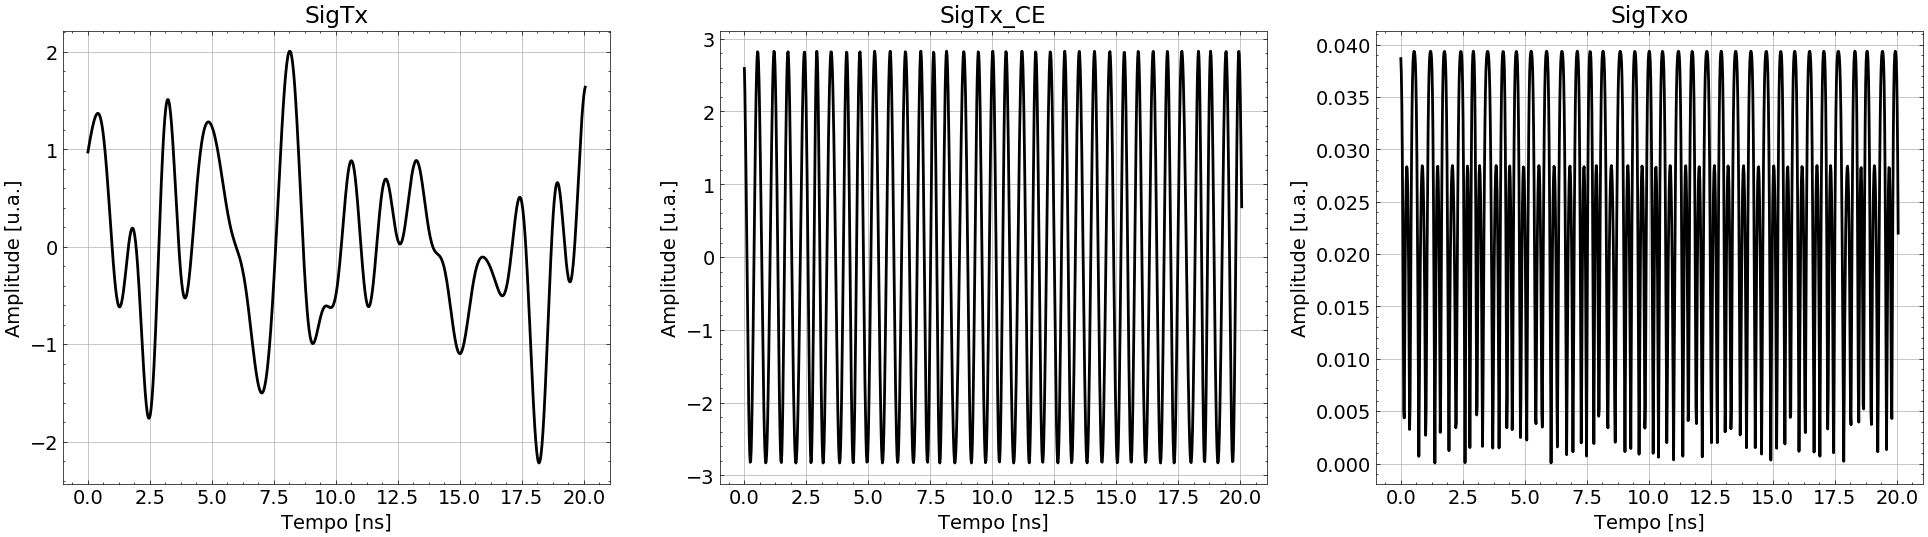

In [297]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))
idX = np.arange(0, 1024)

ax[0].plot(t[idX]*1e9, sigTx[idX].real, lw = 2)
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].set_title('SigTx')
ax[0].grid()

ax[1].plot(t[idX]*1e9, sigTx_CE[idX].real, lw = 2)
ax[1].set_xlabel('Tempo [ns]')
ax[1].set_ylabel('Amplitude [u.a.]')
ax[1].set_title('SigTx_CE')
ax[1].grid()

ax[2].plot(t[idX]*1e9, np.abs(sigTxo[idX]), lw = 2)
ax[2].set_xlabel('Tempo [ns]')
ax[2].set_ylabel('Amplitude [u.a.]')
ax[2].set_title('SigTxo')
ax[2].grid()

#### Espectros

(-205, -90.94966303345436)

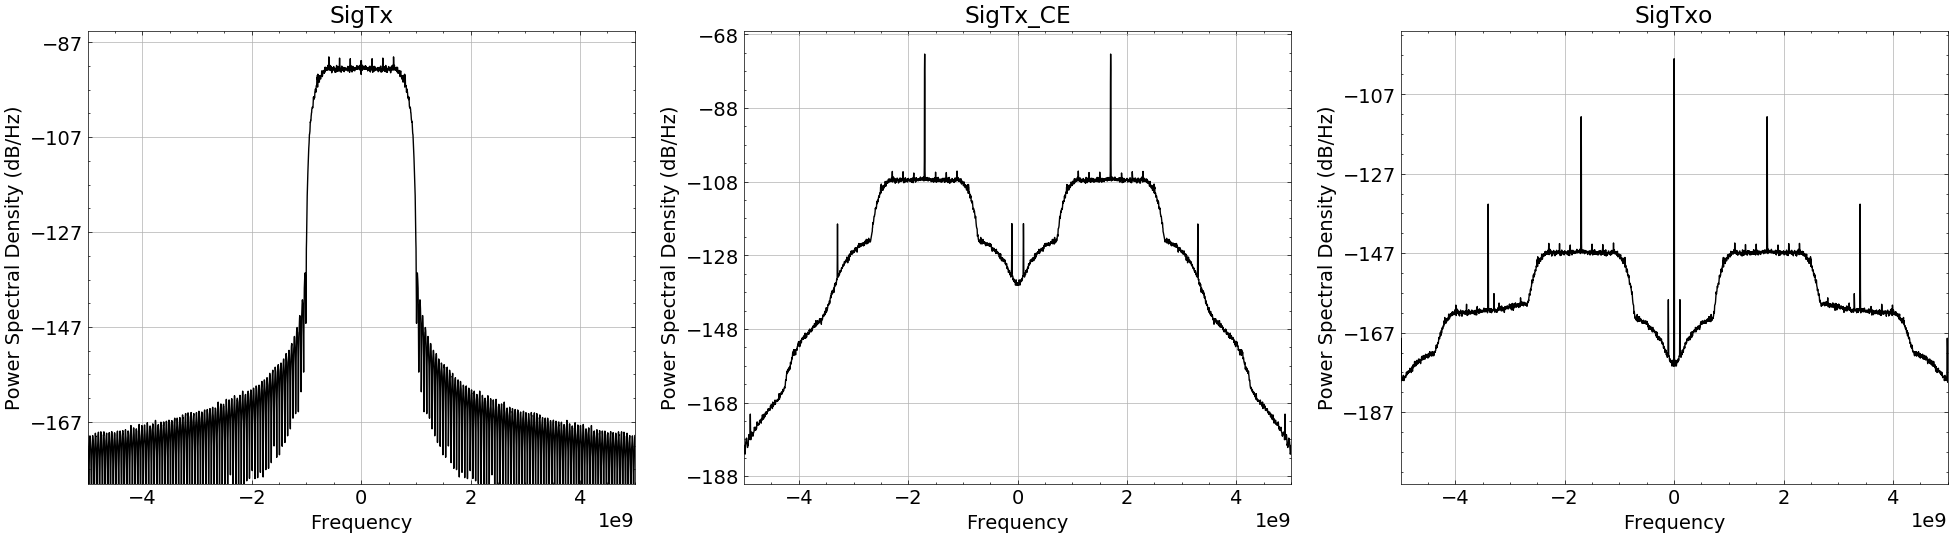

In [217]:
fig, ax = plt.subplots(1, 3, figsize = (24, 6))
idX = np.arange(0, 512)

ax[0].psd(sigTx, Fs=Fa, NFFT = 16*1024, sides='twosided')
ax[0].set_title('SigTx')
ax[0].set_xlim(-5e9, 5e9)
ax[0].set_ylim(-180)

ax[1].psd(sigTx_CE, Fs=Fa, NFFT = 16*1024, sides='twosided')
ax[1].set_title('SigTx_CE')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-190)

ax[2].psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided')
ax[2].set_title('SigTxo')
ax[2].set_xlim(-5e9, 5e9)
ax[2].set_ylim(-205)

In [218]:
# Potência do sinal óptico
print(f" SigTxo - Pi[dBm] = {10*np.log10(1000*signal_power(sigTxo))}")

 SigTxo - Pi[dBm] = -1.010121540166211


In [219]:
# PAPR
print('PAPR = %.2f dB' %(PAPR(paramTx.Nfft, sigTx_CE)))

PAPR = 3.01 dB


## 2 - Canal óptico

In [233]:
paramCh = parameters()

# Parâmetros da fibra
paramCh.Ltotal  = 560         # Comprimento total do link [km]
paramCh.Lspan   = 80          # Comprimento de um span de fibra [km]
paramCh.hz      = 0.5         # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 4.5         # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = True

In [234]:
sigRxo,_  = ssfm(sigTxo, Fa, paramCh)

  0%|          | 0/7 [00:00<?, ?it/s]

## 3 - Recepção

In [235]:
paramPD = parameters()

# Parâmetros do fotodetector
paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 10e9         # Largura de banda [Hz]
paramPD.Fa = Fa          # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = False    # Definição do modelo: ideal ou real

In [236]:
ipd = photodiode(sigRxo, paramPD)

In [237]:
paramRx = parameters()

# Parâmetros do receptor
paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = Fa                # Frequência de amostragem
paramRx.H   = paramTx.H         # Índice de modulação
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Scheme = paramTx.Scheme

paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

In [238]:
symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

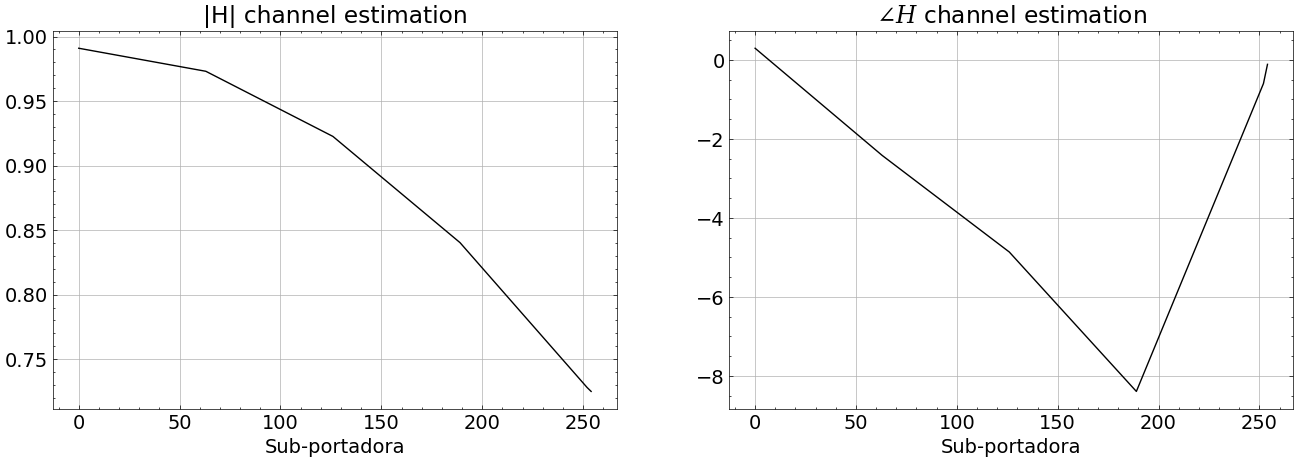

In [239]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(H_abs)
ax[0].set_title("|H| channel estimation")
ax[0].set_xlabel("Sub-portadora")
ax[0].grid()

ax[1].plot(H_pha*180/pi)
ax[1].set_title(r"$\angle H$ channel estimation")
ax[1].set_xlabel("Sub-portadora")
ax[1].grid()

#### Sinal óptico recebido

(-20000000000.0, 20000000000.0)

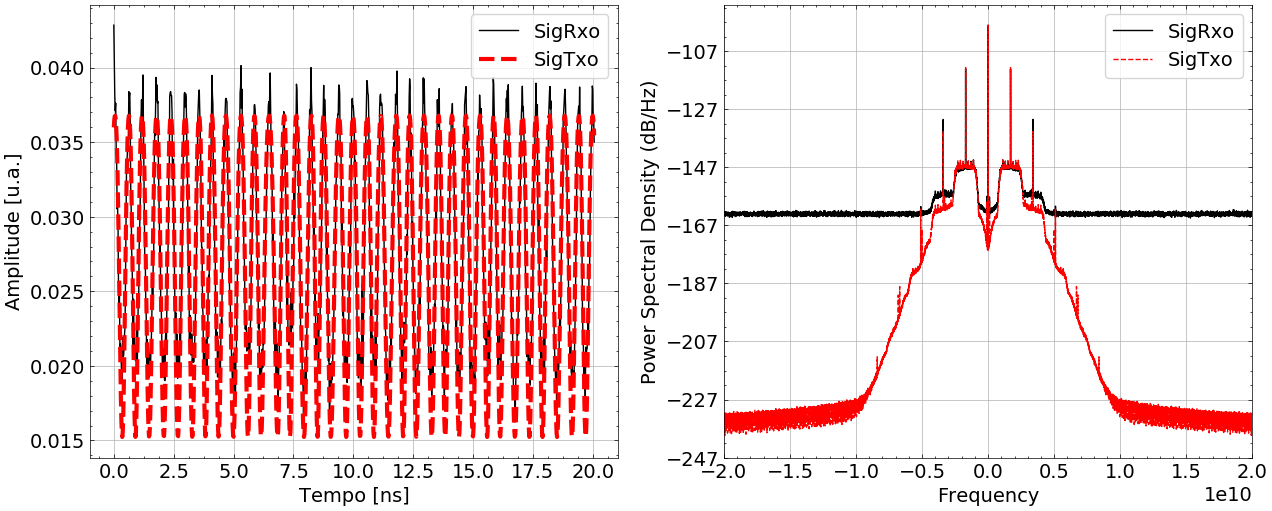

In [240]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
idX = np.arange(0, 1024)

ax[0].plot(t[idX]*1e9, np.abs(sigRxo[idX]), label = "SigRxo")
ax[0].plot(t[idX]*1e9, np.abs(sigTxo[idX]), lw = 3, ls = '--', label = "SigTxo")
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].legend(frameon = True)
ax[0].grid()

ax[1].psd(sigRxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = "SigRxo")
ax[1].psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = "SigTxo")
ax[1].legend(frameon = True)
ax[1].set_xlim(-20e9, 20e9)

#### Sinal elétrico recebido

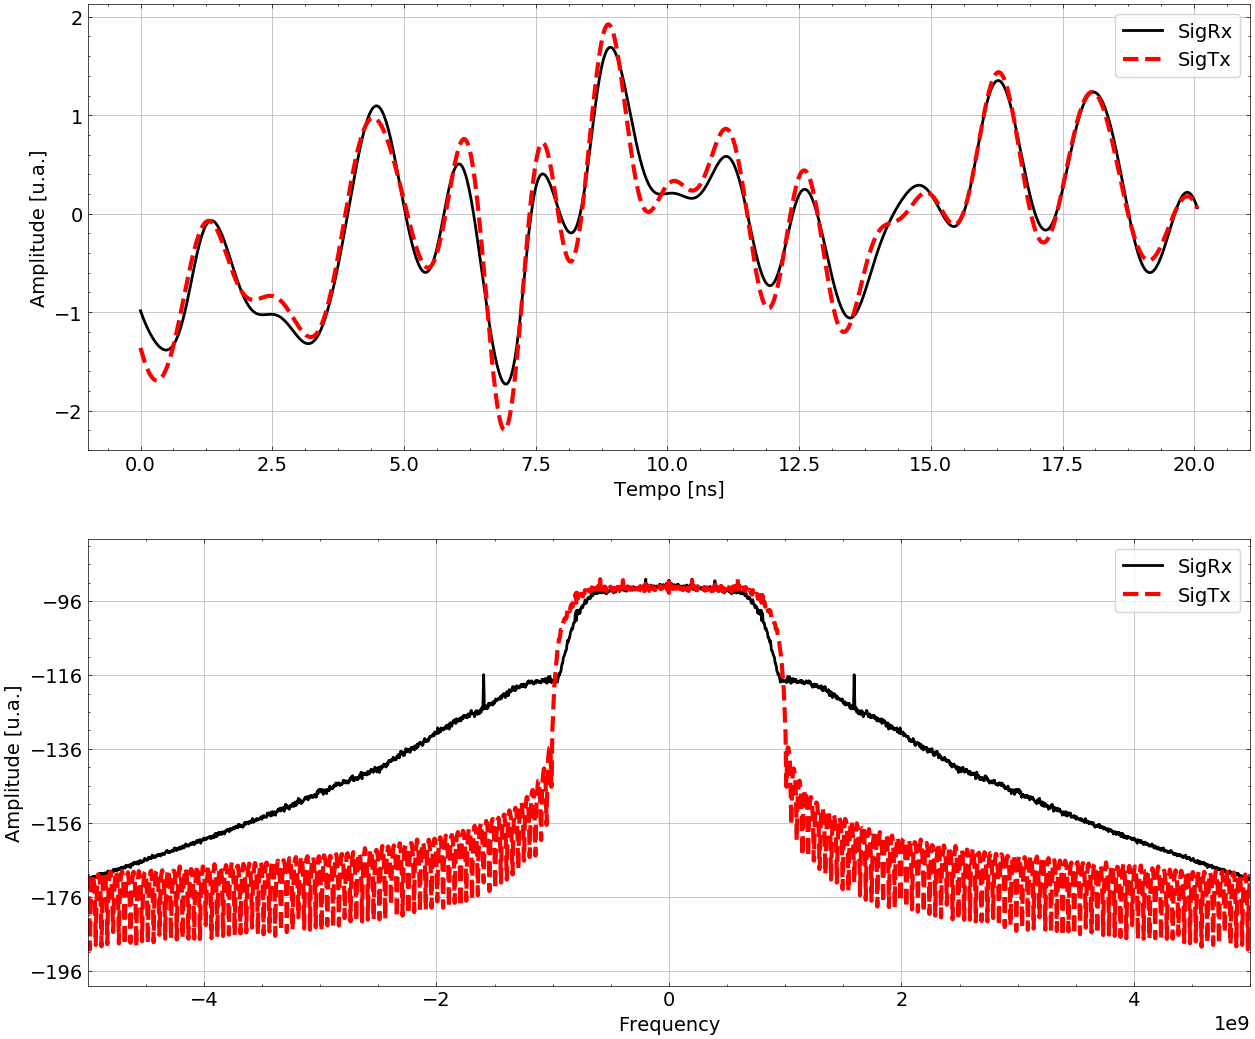

In [241]:
fig, ax = plt.subplots(2, 1, figsize = (15, 13))
idX = np.arange(0, 1024)

ax[0].plot(t[idX]*1e9, sigRx[idX], lw = 2, label = "SigRx")
ax[0].plot(t[idX]*1e9, sigTx[idX].real, lw = 3, label = "SigTx")
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].legend(frameon = True)
ax[0].grid()

ax[1].psd(sigRx, Fs=Fa, NFFT = 16*1024, lw = 2, sides='twosided', label = "SigRx")
ax[1].psd(sigTx, Fs=Fa, NFFT = 16*1024, lw = 3, sides='twosided', label = "SigTx")
ax[1].set_ylabel('Amplitude [u.a.]')
ax[1].set_xlim(-5e9, 5e9)
ax[1].set_ylim(-200)
ax[1].legend(frameon = True)

## 4 - Desempenho do sistema

### 4.1 - Com equalização

In [242]:
# Cálculo da BER
np.log10(fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0])

array([-4.07441746])

(-2, 2)

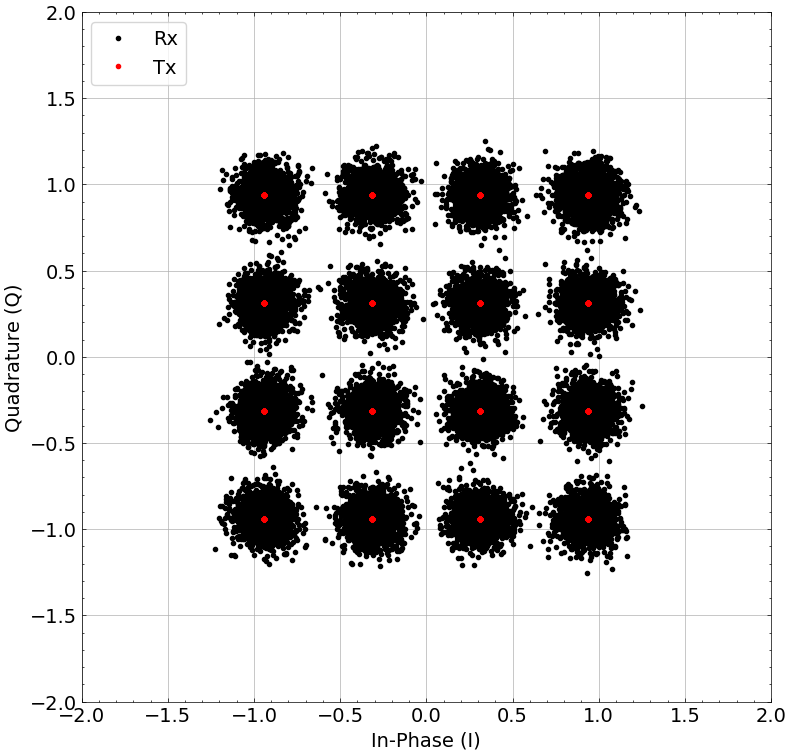

In [243]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(8, 8))
plt.plot(symbRx.real, symbRx.imag, '.', label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left', frameon = True)
plt.tight_layout()
plt.grid()

plt.xlim(-2,2)
plt.ylim(-2,2)

### 4.2 - Sem equalização

In [244]:
# Cálculo da BER
np.log10(fastBERcalc(symbRx_neq, symbTx, paramTx.M, 'qam')[0])

array([-2.80617997])

(-2, 2)

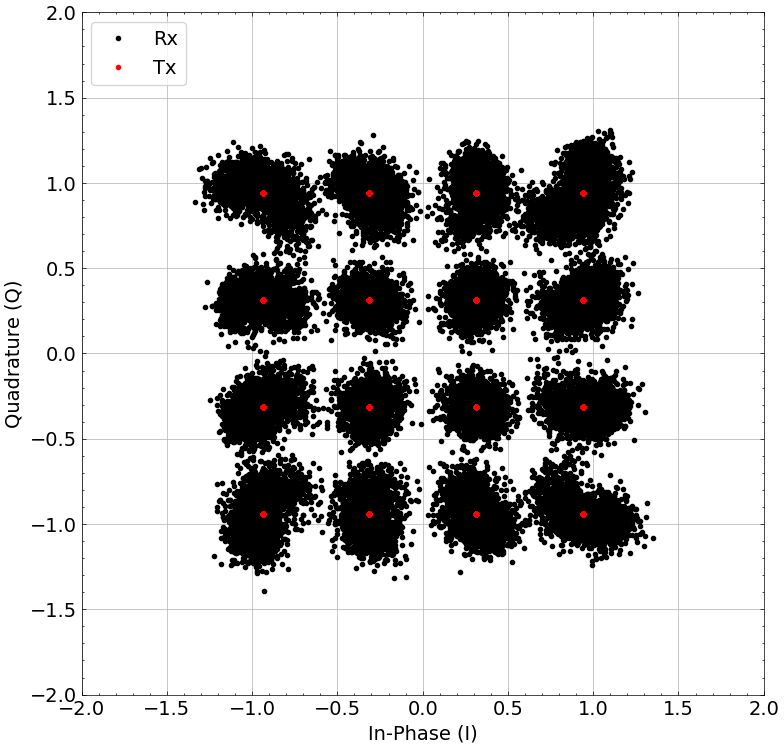

In [245]:
# Plot da constelação transmitida e recebida
plt.figure(figsize=(8, 8))
plt.plot(symbRx_neq.real, symbRx_neq.imag, '.',label = 'Rx')
plt.plot(symbTx.real, symbTx.imag, '.', label = 'Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc = 'upper left', frameon = True)
plt.tight_layout()
plt.grid()

plt.xlim(-2,2)
plt.ylim(-2,2)

In [ ]:
# Escolha do Vpi, Vbias e parâmetro OMI (amanhã - 01-12)
# Sensibilidade do parâmetro de modulação 2.pi.h (02-12)

#-2.9, 10 dBm

# 5 - Parâmetro H em uma transmissão de 800 km, M = 16, Pi = 2 dBm

In [257]:
paramTx.Pi = 2
paramCh.prgsBar = False

In [268]:
H      = np.arange(0.1, 1, 0.1)/(2*pi)
Ltotal = np.array([560, 640, 720])
BER_H  = np.zeros((len(Ltotal), len(H)))

paramCh.hz = 0.5

for i in tqdm(range(len(Ltotal))):
    paramCh.Ltotal = Ltotal[i]
    
    for j in range(len(H)):
        paramTx.H = H[j]
        paramRx.H = H[j]
        
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
        sigRxo,_  = ssfm(sigTxo, Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_H[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/3 [00:00<?, ?it/s]

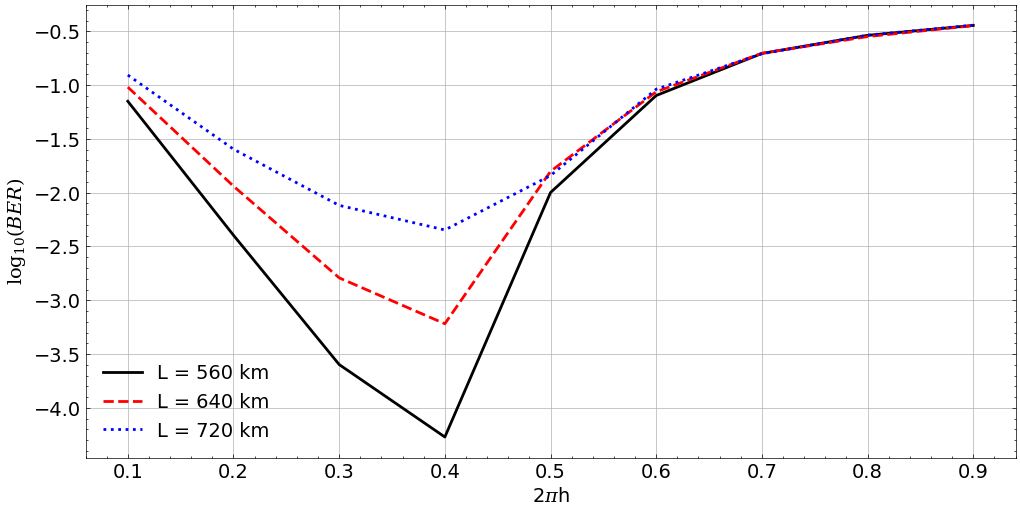

In [271]:
plt.figure(figsize = (12, 6))

for i in range(len(Ltotal)):
    plt.plot(2*pi*H, np.log10(BER_H[i,:]), lw = 2, label = f"L = {Ltotal[i]} km")
    
plt.xlabel(r"2$\pi$h")
plt.ylabel(r"$\log_{10}(BER)$")
plt.grid()
plt.legend()

# 6 - OMI e Vbias 

In [310]:
Vrms = np.sqrt((sigTx_CE.real**2).mean())

In [306]:
OMI = np.arange(0.1, 0.6, 0.1)
Vb  = np.array([-0.5, -0.6, -0.7])*paramTx.Vπ
A   = np.sqrt(2)*paramTx.Vπ*OMI
BER_OMI  = np.zeros((len(Vb), len(OMI)))

paramTx.Pi_dBm = 2
paramTx.H = 0.4/(2*pi)
paramRx.H = 0.4/(2*pi)
paramCh.Ltotal = 560
paramCh.hz = 0.5

for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for j in range(len(OMI)):
        paramTx.A = A[j]
        
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)
        sigRxo,_  = ssfm(sigTxo, Fa, paramCh)
        ipd = photodiode(sigRxo, paramPD)
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_OMI[i, j] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')[0]

  0%|          | 0/3 [00:00<?, ?it/s]

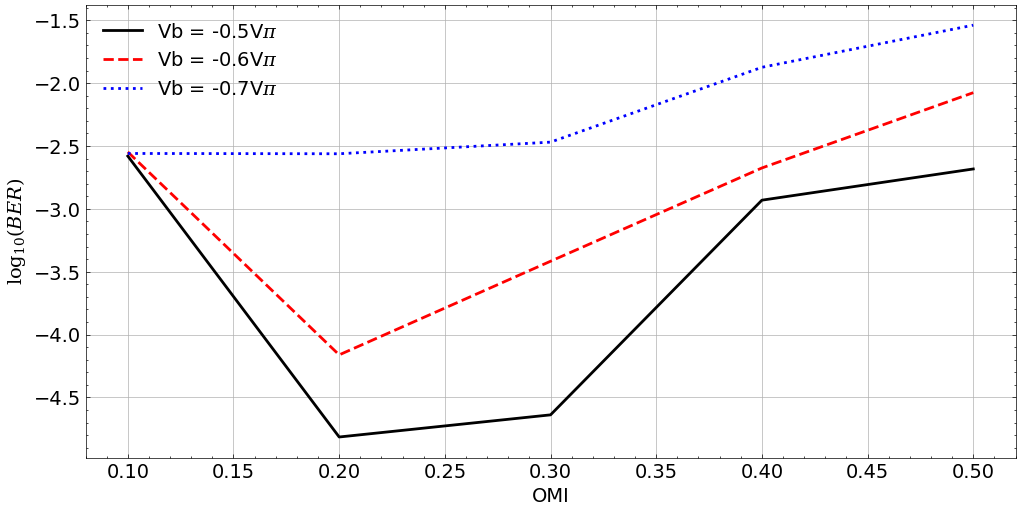

In [307]:
plt.figure(figsize = (12, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_OMI[i,:]), lw = 2, label = f"Vb = {round(Vb[i]/paramTx.Vπ, 1)}V$\pi$")
    
plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.grid()
plt.legend()